# Lab04

In this lab, yolov4 was implimented using DarkNet as its backbone. Since the given config file as well as the architechture of the DarkNet were specifically for yolov3, a new config file and some modifications to the DarkNet architechture were necessary. The config file for yolov4 and the pretrained weights were taken from https://github.com/AlexeyAB/darknet/blob/master/cfg/yolov4-csp.cfg and https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights respectively.

Apart from the those, some modifications of the DarkNet architechture are as follows:

<b>Maxpool (Ref: Prof. Matt)</b>

(in forward:) <br> 
&emsp;&emsp;if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":<br>
&emsp;&emsp;&emsp;&emsp;x = self.module_list[i](x)

(in create_modules:)<br>
&emsp;&emsp;elif x["type"] == "maxpool":<br>
&emsp;&emsp;&emsp;&emsp;stride = int(x["stride"])<br>
&emsp;&emsp;&emsp;&emsp;size = int(x["size"])<br>
&emsp;&emsp;&emsp;&emsp;assert size % 2<br>
&emsp;&emsp;&emsp;&emsp;maxpool = nn.MaxPool2d(kernel_size=size, stride=stride, padding=size // 2)<br>
&emsp;&emsp;&emsp;&emsp;module.add_module("maxpool_{0}".format(index), maxpool)<br>

<b>Mish activation</b>

class Mish(nn.Module):<br>
&emsp;&emsp;def __init__(self):<br>
&emsp;&emsp;&emsp;&emsp;super().__init__()<br>
&emsp;&emsp;def forward(self, x):<br>
&emsp;&emsp;&emsp;&emsp;return x * torch.tanh(F.softplus(x))<br>

In create module<br>
&emsp;&emsp;elif activation == "mish":<br>
&emsp;&emsp;&emsp;&emsp;activn = Mish()<br>
&emsp;&emsp;&emsp;&emsp;module.add_module("mish_{0}".format(index), activn)<br>

<b>The input image size from 416 x 416 to 608 x 608</b>

<b>The route (Ref: Prof. Matt)</b>

&emsp;&emsp;elif module_type == "route":<br>
&emsp;&emsp;&emsp;&emsp;layers = module["layers"]<br>
&emsp;&emsp;&emsp;&emsp;layers = [int(a) for a in layers]<br>
&emsp;&emsp;if (layers[0]) > 0:<br>
&emsp;&emsp;&emsp;&emsp;layers[0] = layers[0] - i<br>
&emsp;&emsp;if len(layers) == 1:    # 1 item in layer <br>           
&emsp;&emsp;&emsp;&emsp;x = outputs[i + (layers[0])]<br>
&emsp;&emsp;else:# more than 1 item in layer <br>
&emsp;&emsp;&emsp;&emsp;if len(layers) == 4:# 4 items in layer   <br>                                   
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if (layers[1]) > 0:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;layers[1] = layers[1] - i<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if (layers[2]) > 0:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;layers[2] = layers[2] - i<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if (layers[3]) > 0:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;layers[3] = layers[3] - i<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;map1 = outputs[i + layers[0]]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;map2 = outputs[i + layers[1]]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;map3 = outputs[i + layers[2]]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;map4 = outputs[i + layers[3]]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;x = torch.cat((map1, map2, map3, map4), 1)<br>
&emsp;&emsp;&emsp;&emsp;else: # 2 items in layer <br>               
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if (layers[1]) > 0:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;layers[1] = layers[1] - i<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;map1 = outputs[i + layers[0]]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;map2 = outputs[i + layers[1]]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;x = torch.cat((map1, map2), 1)<br>
                
<b>Conversion of colors in prep_images</b>

&emsp;&emsp;def prep_image(img, inp_dim):<br>
&emsp;&emsp;&emsp;&emsp;img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)<br>
&emsp;&emsp;&emsp;&emsp;img = letterbox_image(img, (inp_dim, inp_dim))<br>
&emsp;&emsp;&emsp;&emsp;return torch.from_numpy(img.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0)<br>

As for the inference, I have tested yolov4 with some COCO images, the results can be seen below. <br>
Note that I have also converted the images from RGB back to BGR since during the prep_image the images were converted from BGR to RGB.<br>

In [9]:
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/darknet.py

--2021-03-06 06:34:22--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/darknet.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 11533 (11K) [text/plain]
Saving to: ‘darknet.py.1’

darknet.py.1        100%[===================>]  11.26K  --.-KB/s    in 0.001s  

2021-03-06 06:34:23 (13.8 MB/s) - ‘darknet.py.1’ saved [11533/11533]



In [5]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

images = "cocoimages"
batch_size = 4
confidence = 0.5
nms_thesh = 0.4
start = 0
CUDA = torch.cuda.is_available()

num_classes = 80
classes = load_classes("data/coco.names")

#Set up the neural network

print("Loading network.....",file=open("output_coco.txt", "a"))
model = Darknet("cfg/yolov4.cfg")
model.module_list[114].conv_114 = nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
model.load_weights("weights/yolov4.weights")
print("Network successfully loaded",file=open("output_coco.txt", "a"))

model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU

if CUDA:
    model.cuda()

# Set the model in evaluation mode

model.eval()

read_dir = time.time()

# Detection phase

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images),file=open("output_coco.txt", "a"))
    exit()
    
if not os.path.exists("des"):
    os.makedirs("des")

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]  

write = 0

if CUDA:
    im_dim_list = im_dim_list.cuda()
    
start_det_loop = time.time()
for i, batch in enumerate(im_batches):
    # Load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size),file=open("output_coco.txt", "a"))
            print("{0:20s} {1:s}".format("Objects Detected:", ""),file=open("output_coco.txt", "a"))
            print("----------------------------------------------------------",file=open("output_coco.txt", "a"))
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    if not write:                      #If we have't initialised output
        output = prediction  
        write = 1
    else:
        output = torch.cat((output,prediction)) #what for

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size),file=open("output_coco.txt", "a"))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)),file=open("output_coco.txt", "a"))
        print("----------------------------------------------------------",file=open("output_coco.txt", "a"))

    if CUDA:
        torch.cuda.synchronize()       
try:
    output
except NameError:
    print ("No detections were made",file=open("output_coco.txt", "a"))
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
output_recast = time.time()
class_load = time.time()
colors = [[255, 0, 0], [255, 0, 0], [255, 255, 0], [0, 255, 0], [0, 255, 255], [0, 0, 255], [255, 0, 255]]

draw = time.time()

def write(x, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("des",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))

end = time.time()

print("SUMMARY",file=open("output_coco.txt", "a"))
print("----------------------------------------------------------",file=open("output_coco.txt", "a"))
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"),file=open("output_coco.txt", "a"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir),file=open("output_coco.txt", "a"))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch),file=open("output_coco.txt", "a"))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop),file=open("output_coco.txt", "a"))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast),file=open("output_coco.txt", "a"))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw),file=open("output_coco.txt", "a"))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)),file=open("output_coco.txt", "a"))
print("----------------------------------------------------------",file=open("output_coco.txt", "a"))


torch.cuda.empty_cache()

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 10.76 GiB total capacity; 1.51 GiB already allocated; 13.56 MiB free; 1.55 GiB reserved in total by PyTorch)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'draw', 'colors', 'unique']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


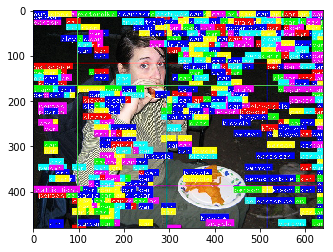

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("des/det_000000018193.jpg")
plt.imshow(image)
plt.show()

### Inference on COCO dataset

In [5]:
results_COCO = open("output_coco.txt", "r")
print(results_COCO.read())

Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
Loading network.....
Network successfully loaded
000000016502.jpg     predicted in  3.462 seconds
Objects Detected:    frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee f

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob
for img in glob.glob("des/*.jpg"):
    cv_img = cv2.imread(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    plt.imshow(cv_img)
    plt.show()